In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local') \
    .appName('ETL') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()
sc = spark.sparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, BooleanType, StringType

schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("stream", IntegerType(), True),
    StructField("sent", BooleanType(), True),
    StructField("seqnum", IntegerType(), True),
    StructField("ack", BooleanType(), True),
    StructField("acknum", IntegerType(), True)
])

In [13]:
def read_npz_to_df(filename):
    data = np.load(filename+'.npz')['packets']
    pd_df = pd.DataFrame(data=data)
    pd_df.drop(columns=['src', 'dst', 'src_port', 'dst_port'], inplace=True)
    pd_df.to_csv(filename+'.csv', index=False)
    df = spark.read.option("header", "true").csv(filename+'.csv')
    return df

def find_ack_for_seq(df):
    df.createOrReplaceTempView("df")
    df_joined = spark.sql("""
                select df1.stream, df1.timestamp, df1.sent, df1.seqnum, min(df2.timestamp) as acktimestamp 
                from df df1 inner join df df2 
                on df1.seqnum<df2.acknum 
                and df1.sent!=df2.sent
                and df1.stream=df2.stream
                group by df1.stream, df1.timestamp, df1.seqnum, df1.sent
                order by df1.stream
                """)
    return df_joined

def shift_windows(df, streamno):
    shift_window = Window.partitionBy().orderBy('timestamp')
    #calculate sequence length
    df.createOrReplaceTempView("df")

    df_shifted = spark.sql("select * from df where stream={} and sent=True".format(streamno))

    df_shifted = df_shifted.withColumn('seqnum_1', F.lag(df_shifted.seqnum).over(shift_window))
    df_shifted = df_shifted.withColumn('seqlength', F.when(F.isnull(df_shifted.seqnum - df_shifted.seqnum_1), 0)
                          .otherwise(df_shifted.seqnum - df_shifted.seqnum_1))
    #calculate g_in
    df_shifted = df_shifted.withColumn('timestamp_1', F.lag(df_shifted.timestamp).over(shift_window))
    df_shifted = df_shifted.withColumn('gin', F.when(F.isnull(df_shifted.timestamp - df_shifted.timestamp_1), 0)
                          .otherwise(df_shifted.timestamp - df_shifted.timestamp_1))
    #calculate g_ack
    df_shifted = df_shifted.withColumn('acktimestamp_1', F.lag(df_shifted.acktimestamp).over(shift_window))
    df_shifted = df_shifted.withColumn('gack', F.when(F.isnull(df_shifted.acktimestamp - df_shifted.acktimestamp_1), 0)
                          .otherwise(df_shifted.acktimestamp - df_shifted.acktimestamp_1))
    return df_shifted

def sanity_check(df):
    df.createOrReplaceTempView("df_shifted")
    df_sanity = spark.sql("""
                            select  timestamp, timestamp_1, seqnum, seqnum_1, seqlength, gin 
                            from df_shifted 
                            where df_shifted.seqlength<0 
                            and sent=True 
                            and stream=0 
                            order by timestamp asc
                            """)
    if df_sanity.count()==0:
        return True
    else:
        return False

def get_stream_arrays(df, streamno):
    df.createOrReplaceTempView("df_stream")
    stream = spark.sql("""
                        select * from df_stream
                        where df_stream.stream={}
                        """.format(streamno))\
    .rdd.map(lambda row: (row.timestamp, row.seqlength, row.gin, row.gack))
    ts_array = np.array(stream.map(lambda ts_l: ts_l[0]).collect())
    l_array = np.array(stream.map(lambda ts_l: ts_l[1]).collect())
    gin_array = np.array(stream.map(lambda ts_l: ts_l[2]).collect())
    gack_array = np.array(stream.map(lambda ts_l: ts_l[3]).collect())
    return ts_array, l_array, gin_array, gack_array

In [14]:
filename = 'dumpfile17'
streamno = 0
df = read_npz_to_df(filename)
df_joined = find_ack_for_seq(df)
df_shifted = shift_windows(df_joined, streamno)
if sanity_check(df_shifted):
    ts_array, l_array, gin_array, gack_array = get_stream_arrays(df_shifted, streamno)

2830.3239740820736 315.97876806179266 0.0 2896.0 2896.0


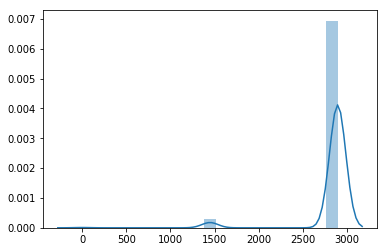

In [15]:
sns.distplot(l_array)
print(l_array.mean(), l_array.std(), l_array.min(), l_array.max(), np.median(l_array))

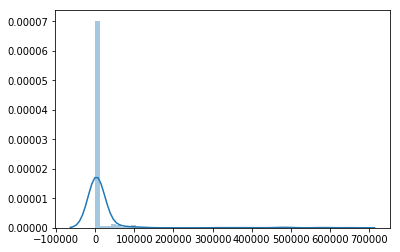

In [16]:
sns.distplot(gin_array)

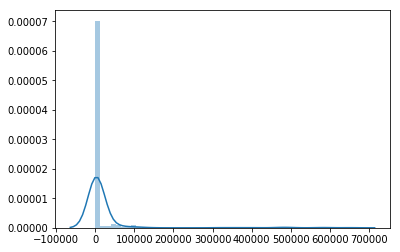

In [17]:
sns.distplot(gack_array)

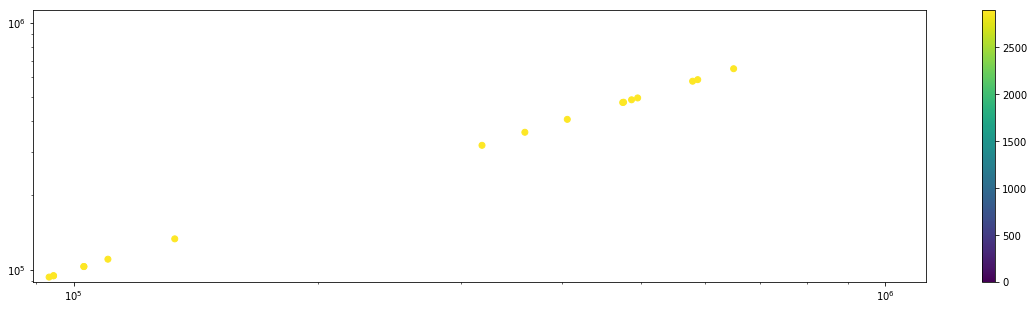

In [18]:
plt.figure(figsize=(20,5))
plt.scatter(gin_array, gack_array, c=l_array)
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

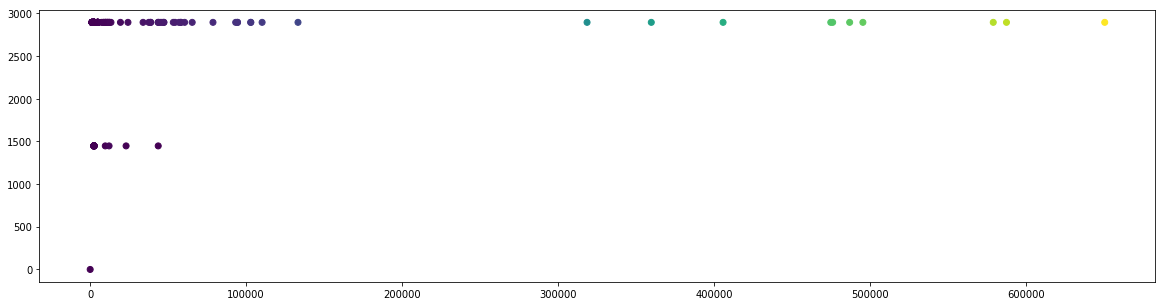

In [19]:
plt.figure(figsize=(20,5))
plt.scatter(gin_array, l_array, c=gack_array)
#plt.yscale('log')
#plt.xscale('log')

/home/saghar/.virtualenvs/spark3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


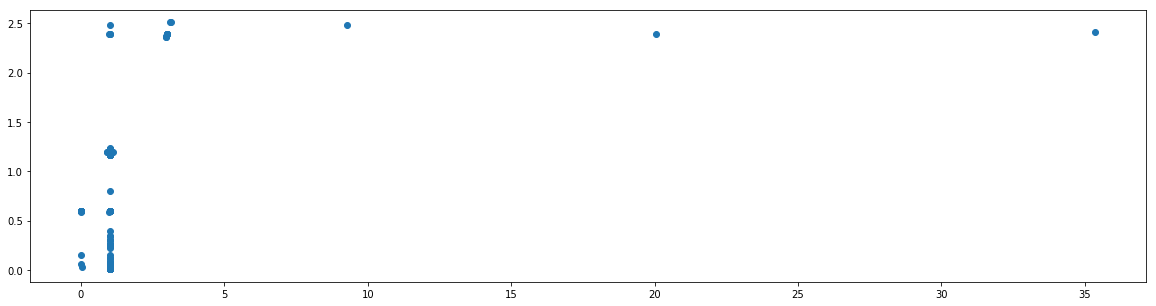

In [20]:
plt.figure(figsize=(20,5))
plt.plot(gack_array/gin_array, l_array/gin_array, 'o')
#plt.yscale('log')
#plt.xscale('log')


In [27]:
df_shifted.select(['gin', 'gack']).show()
#df_shifted.select('gin').rdd.flatMap(list).collect()

+--------+--------+
|     gin|    gack|
+--------+--------+
|     0.0|     0.0|
|  4846.0|  4850.0|
|  2423.0|  2423.0|
|  2420.0|  2410.0|
|  2424.0|  2427.0|
|  2421.0|  2417.0|
|  2422.0|  2423.0|
|  2426.0|  2436.0|
|  2423.0|  2430.0|
|475998.0|475992.0|
|  2425.0|  2422.0|
|  2421.0|  2425.0|
|  2424.0|  2423.0|
|  2431.0|  2426.0|
|  2411.0|  2403.0|
|  2421.0|  2418.0|
|  2424.0|  2427.0|
|  2437.0|  2431.0|
|  2407.0|  2407.0|
|  2423.0|  2429.0|
+--------+--------+
only showing top 20 rows

